## Always be suspicious of any experiment without any uncertainty metric

Lets have a look at some educational data.
Below is compiled data on ENEM scores (Brazilian standardised high school scores, similar to SAT) from different schools for 3 years

In [6]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt

In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/aps0611/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/enem_scores.csv")
df.sort_values(by="avg_score", ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


If we look at the top-performing school, something catches the eye: those schools have a reasonably small number of students.

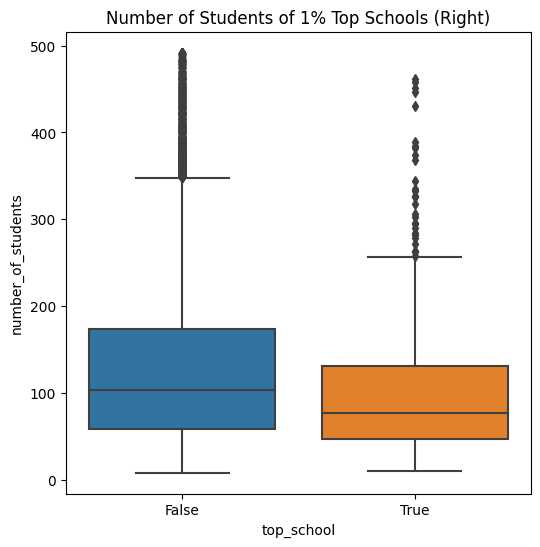

In [8]:
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(6,6))
sns.boxplot(x="top_school", y="number_of_students", data=plot_data)
plt.title("Number of Students of 1% Top Schools (Right)");

Why is this dangerous?

What people forgot to do was to look also at the bottom 1% of schools. If we do that, lo and behold! They also have very few students!

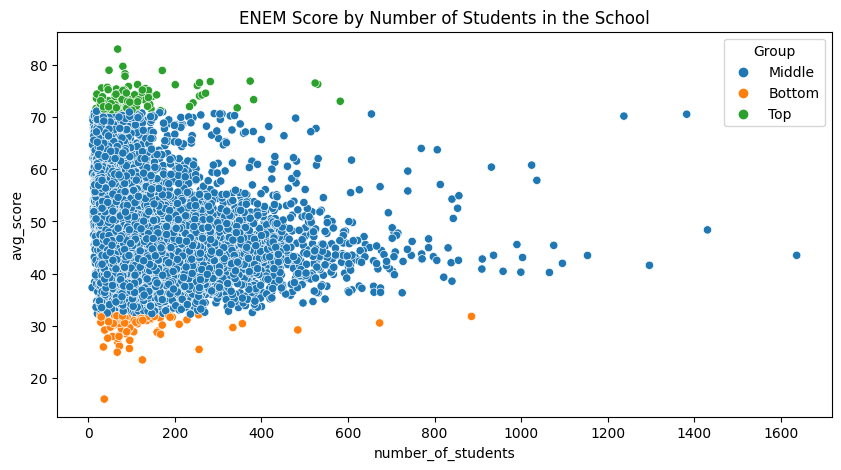

In [5]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d: np.select([d["avg_score"] > q_99, d["avg_score"] < q_01],
                                                 ["Top", "Bottom"], "Middle")))
plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", x="number_of_students", hue="Group", data=plot_data)
plt.title("ENEM Score by Number of Students in the School");

 As the number of students grows, the average score becomes more and more precise.

Schools with very few samples can have very high and low scores simply due to chance. This is less likely to occur in large schools.

 Moivre’s equation talks about a fundamental fact about the reality of information and records in the form of data: it is always imprecise. The question then becomes how inaccurate.

One way to quantify our uncertainty is the variance of our estimates. Variance tells us how much observation deviates from its central and most probable value. As Moivre’s equation indicates, this uncertainty shrinks as the amount of data we observe increases

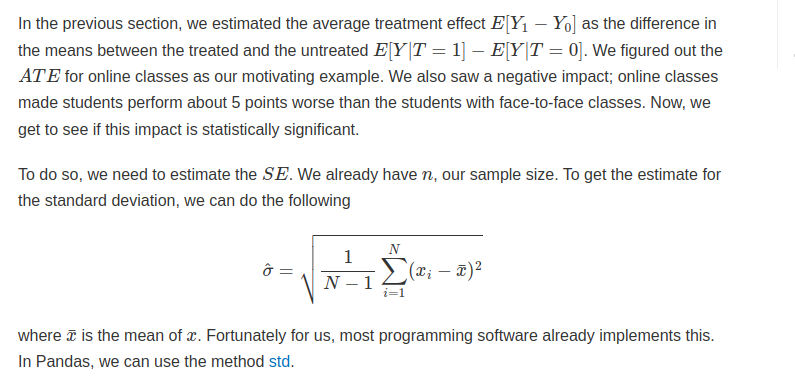

In [10]:
data = pd.read_csv("https://raw.githubusercontent.com/aps0611/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/online_classroom.csv")
data.head(10)

,gender,asian,black,hawaiian,hispanic,unknown,white,format_ol,format_blended,falsexam
0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,63.29997
1,1,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,79.96000
2,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,83.37000
3,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,90.01994
4,1,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,83.30000
5,0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.0,88.34996
6,1,1.0,0.0,0.0,0.0,0.0,0.0,0,1.0,78.40000
7,1,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,90.00000
8,1,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,88.31000
9,0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,73.37000


In [11]:
online = data.query("format_ol==1")["falsexam"]
face_to_face = data.query("format_ol==0 & format_blended==0")["falsexam"]

def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print("SE for Online:", se(online))
print("SE for Face to Face:", se(face_to_face))

SE for Online: 1.5371593973041635
SE for Face to Face: 0.8723511456319106


## Confidence Intervals

Let’s suppose we have a true abstract distribution of students’ test scores to better grasp this. This is a normal distribution with a true mean of 74 and a true standard deviation of 2. From this distribution, we can run 10000 experiments. On each one, we collect 500 samples. If we plot them in a histogram, we can see that means of the experiments are distributed around the true mean. Some experiment data will have a mean lower than the true one, and some will be higher.

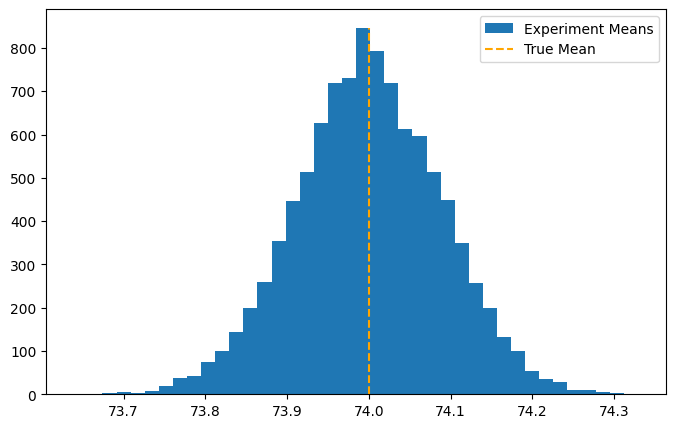

In [12]:
true_std = 2
true_mean = 74

n = 500
def run_experiment():
    return np.random.normal(true_mean,true_std, 500)

np.random.seed(42)

plt.figure(figsize=(8,5))
freq, bins, img = plt.hist([run_experiment().mean() for _ in range(10000)], bins=40, label="Experiment Means")
plt.vlines(true_mean, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="orange")
plt.legend();

## with the standard error, we can create an interval that will contain the true mean 95% of the time.

`To calculate the confidence interval, we use the central limit theorem. This theorem states that means of experiments are normally distributed. From statistical theory, we know that 95% of the mass of a normal distribution is between 2 standard deviations above and below the mean. Technically, 1.96, but 2 is close enough.`

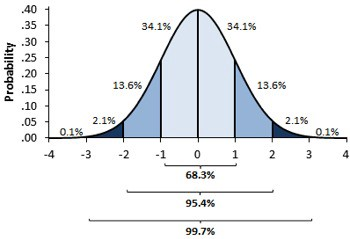

The Standard Error of the mean serves as our estimate of the distribution of the experiment means. So, if we multiply it by 2 and add and subtract it from the mean of one of our experiments, we will construct a 95% confidence interval for the true mean.

In [13]:
np.random.seed(321)
exp_data = run_experiment()
exp_se = exp_data.std() / np.sqrt(len(exp_data))
exp_mu = exp_data.mean()
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)
print(ci)

(73.82718114045632, 74.17341543460314)


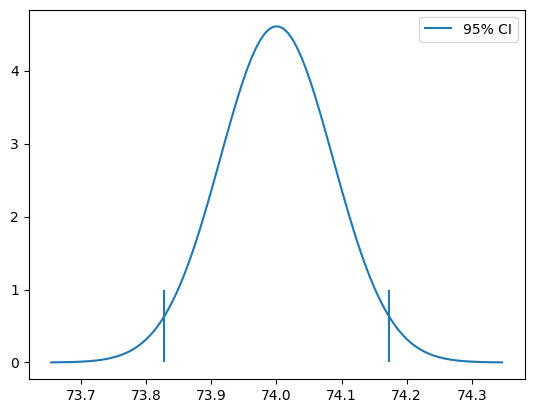

In [14]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="95% CI")
plt.legend()
plt.show()

In [15]:
from scipy import stats
z = stats.norm.ppf(.995) ## ppf gives inverse of cdf
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(73.7773381773405, 74.22325839771896)

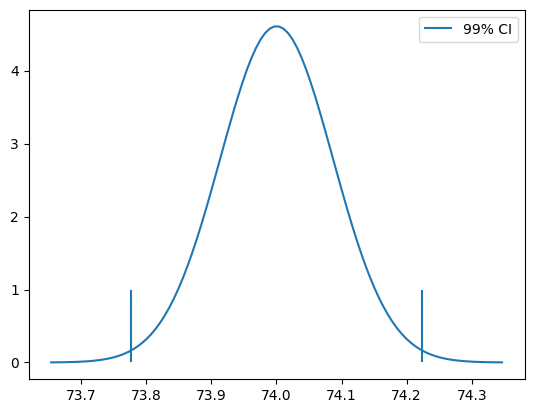

In [16]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="99% CI")
plt.legend()
plt.show()

In [17]:
def ci(y: pd.Series):
    return (y.mean() - 2 * se(y), y.mean() + 2 * se(y))

print("95% CI for Online:", ci(online))
print("95% for Face to Face:", ci(face_to_face))

95% CI for Online: (70.56094429049804, 76.7095818797147)
95% for Face to Face: (76.80278229206951, 80.29218687459715)


# We can see that the 95% CI of the groups doesn’t overlap. The lower end of the CI for Face to Face class is above the upper end of the CI for online classes. This is evidence that our result is not by chance and that the true mean for students in face-to-face classes is higher than the true mean for students in online classes. In other words, there is a significant causal decrease in academic performance when switching from face-to-face to online classes.

# The smaller the sample size, the larger the standard error, and the wider the confidence interval

confidence intervals are a way to place uncertainty around our estimates

# Hypothesis Testing

Another way to incorporate uncertainty is to state a hypothesis test: is the difference in means statistically different from zero (or any other value)?

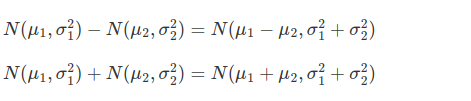

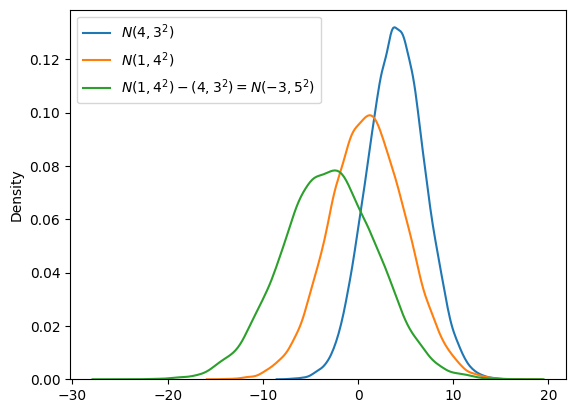

In [18]:
np.random.seed(123)
n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1
sns.distplot(n1, hist=False, label="$N(4,3^2)$")
sns.distplot(n2, hist=False, label="$N(1,4^2)$")
sns.distplot(n_diff, hist=False, label=f"$N(1,4^2) - (4,3^2) = N(-3, 5^2)$")
plt.legend()
plt.show()

class room example

In [19]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)
print(ci)

(-8.376410208363385, -1.4480327880905248)


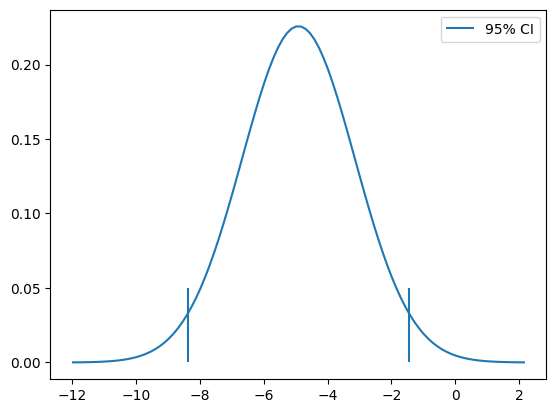

In [20]:
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=.05)
plt.vlines(ci[0], ymin=0, ymax=.05, label="95% CI")
plt.legend()
plt.show()

In [21]:
z = diff_mu / diff_se
print(z)

-2.7792810791031224


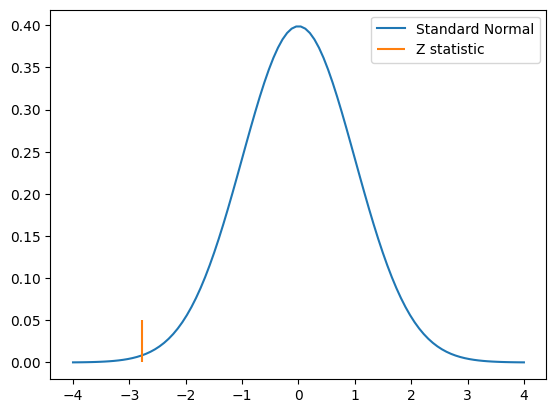

In [22]:
x = np.linspace(-4,4,100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, label="Standard Normal")
plt.vlines(z, ymin=0, ymax=.05, label="Z statistic", color="C1")
plt.legend()
plt.show()

# if the confidence intervals in the two groups overlap, it can still be the case that the result is statistically significant.

## Its preferable to use Hypothesis Testing

the p-value is the probability of seeing such data, given that the null hypothesis is true

It measures how unlikely it is that you are seeing a measurement if the null hypothesis is true. Naturally, this often gets confused with the probability of the null hypothesis being true. Note the difference here. The p-value is NOT P(H0| data)
, but rather `P(data| H0)`
.

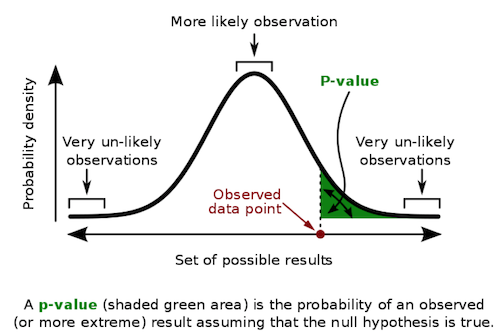

In [23]:
print("P-value:", stats.norm.cdf(z))

P-value: 0.0027239680835563383


WRAP UP

In [24]:
def AB_test(test: pd.Series, control: pd.Series, confidence=0.95, h0=0):
    mu1, mu2 = test.mean(), control.mean()
    se1, se2 = test.std() / np.sqrt(len(test)), control.std() / np.sqrt(len(control))

    diff = mu1 - mu2
    se_diff = np.sqrt(test.var()/len(test) + control.var()/len(control))

    z_stats = (diff-h0)/se_diff
    p_value = stats.norm.cdf(z_stats)

    def critial(se): return -se*stats.norm.ppf((1 - confidence)/2)

    print(f"Test {confidence*100}% CI: {mu1} +- {critial(se1)}")
    print(f"Control {confidence*100}% CI: {mu2} +- {critial(se2)}")
    print(f"Test-Control {confidence*100}% CI: {diff} +- {critial(se_diff)}")
    print(f"Z Statistic {z_stats}")
    print(f"P-Value {p_value}")

AB_test(online, face_to_face)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.54748458333333 +- 1.7097768273108005
Test-Control 95.0% CI: -4.912221498226955 +- 3.4641250548559537
Z Statistic -2.7792810791031224
P-Value 0.0027239680835563383


In [25]:
AB_test(online, face_to_face, h0=-1)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.54748458333333 +- 1.7097768273108005
Test-Control 95.0% CI: -4.912221498226955 +- 3.4641250548559537
Z Statistic -2.2134920404560883
P-Value 0.013431870694630114


In [26]:

'''

P.S. This is my draft document. I am learning causal inference through open source material.
For orginal content please read more below:
Read more here:
https://matheusfacure.github.io/python-causality-handbook/01-Introduction-To-Causality.html

https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/

https://www.youtube.com/watch?v=CfzO4IEMVUk&list=PLoazKTcS0Rzb6bb9L508cyJ1z-U9iWkA0
'''

'\n\nP.S. This is my draft document. I am learning causal inference through open source material.\nFor orginal content please read more below:\nRead more here:\nhttps://matheusfacure.github.io/python-causality-handbook/01-Introduction-To-Causality.html\n\nhttps://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/\n\nhttps://www.youtube.com/watch?v=CfzO4IEMVUk&list=PLoazKTcS0Rzb6bb9L508cyJ1z-U9iWkA0\n'